# Testing K-means Clustering
### Use techniques we've already learned in class to try and make progress on identifying roads

Imports

In [2]:
import skimage.io as skio
import skimage.util as sku
import skimage.color as skol
from skimage import filters, feature, transform
import skimage.morphology as skimor
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

### Read data file and show images

In [3]:
image_filepath = "../data/massRoads/tiff"
# /train/... for images and /train_labels/... for labels

In [4]:
image = skio.imread(image_filepath + "/train/10078675_15.tiff")
image_label = skio.imread(image_filepath + "/train_labels/10078675_15.tif")

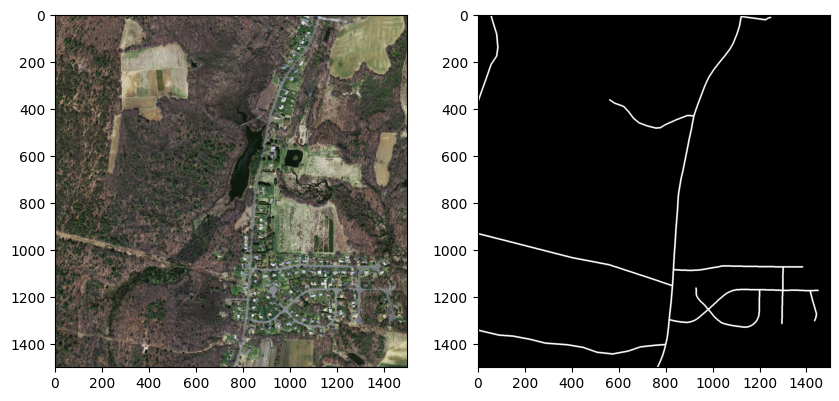

In [5]:
fig, axes = plt.subplots(1,2, figsize = (10,15))

axes[0].imshow(image)
axes[1].imshow(image_label, cmap='gray')

plt.show()

Cropping Image for testing

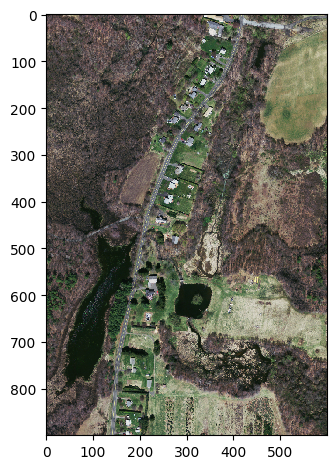

In [6]:
x1, y1 = 700, 0
x2, y2 = 1300, 900
image = image[y1:y2, x1:x2, :]
skio.imshow(image)

### Function for calculating label accuracy

In [7]:
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred)

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # True positive rate
    tpr = (C[0,0])/(C[0,0] + C[0,1])
    
    # True negative rate
    tnr = (C[1,1])/(C[1,0] + C[1,1])

    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nTrue positive rate (not road):", np.round(tpr, 3),
            "\nTrue negative rate (roads)", np.round(tnr, 3)) 

In [8]:
#what values are used in label image
np.unique(image_label)

array([  0, 255], dtype=uint8)

### Reshape image

In [9]:
pixel_vals = image.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)

### K means from sklearn with just RGB

In [13]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(pixel_vals)

Initialization complete
Iteration 0, inertia 790234496.0.
Iteration 1, inertia 565509376.0.
Iteration 2, inertia 562804096.0.
Iteration 3, inertia 561419136.0.
Iteration 4, inertia 560468800.0.
Iteration 5, inertia 559807872.0.
Iteration 6, inertia 559332736.0.
Iteration 7, inertia 558973312.0.
Iteration 8, inertia 558711296.0.
Iteration 9, inertia 558509760.0.
Iteration 10, inertia 558350848.0.
Iteration 11, inertia 558229696.0.
Iteration 12, inertia 558132288.0.
Iteration 13, inertia 558062784.0.
Converged at iteration 13: center shift 0.13665920495986938 within tolerance 0.17208853759765627.


In [14]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


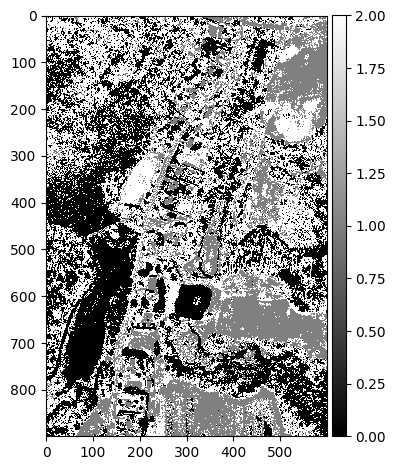

In [15]:
skio.imshow(sk_segmented_image, cmap='gray')

### Let's try to input a few more things into the model

Let's try to put a horizontal and vertically run edge detection using Sobel kernels

In [16]:
image_gray = skol.rgb2gray(image)

# Define Sobel kernels
sobel_horizontal = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

sobel_vertical = np.array([[-1, 0, 1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

# Perform convolutions
edges_horizontal = convolve2d(image_gray, sobel_horizontal, mode='same', boundary='symm')
edges_vertical = convolve2d(image_gray, sobel_vertical, mode='same', boundary='symm')

# Calculate the magnitude of the gradient
edges = np.sqrt(np.square(edges_horizontal) + np.square(edges_vertical))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


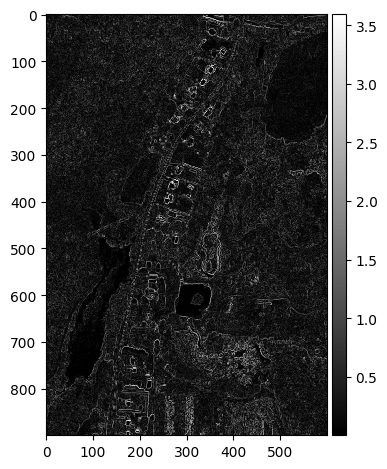

In [17]:
skio.imshow(edges, cmap='gray')

## Let's use canny edge detection instead

In [18]:
# Calculation Canny gradient
canny_edges = feature.canny(image_gray, sigma=3)

### Dilation to create crisper edges

In [19]:
# Create disk
disk = skimor.disk(1)

# Area closing
closed_edges = skimor.dilation(canny_edges, footprint = disk)
closed_edges = closed_edges * 255

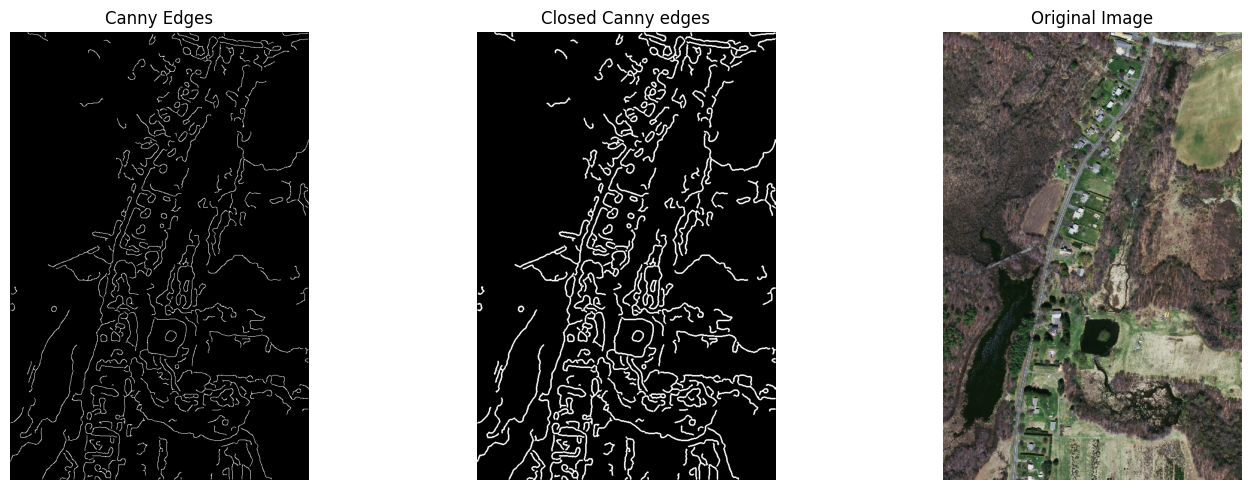

In [20]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(canny_edges, cmap='gray')
ax[0].set_title('Canny Edges')

ax[1].imshow(closed_edges, cmap='gray')
ax[1].set_title('Closed Canny edges')

ax[2].imshow(image)
ax[2].set_title('Original Image')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

Now lets add this new channel to the image and see what happens

In [21]:
image_with_canny = np.dstack((image, closed_edges.astype(np.uint8) * 255))

In [22]:
feature_vals = image_with_canny.reshape((-1,4))
feature_vals = np.float32(feature_vals)

In [23]:
sk_kmeans = KMeans(n_clusters=3, verbose=1).fit(feature_vals)

Initialization complete
Iteration 0, inertia 1052511488.0.
Iteration 1, inertia 610266048.0.
Iteration 2, inertia 566067072.0.
Iteration 3, inertia 559400640.0.
Iteration 4, inertia 558391808.0.
Iteration 5, inertia 558186880.0.
Iteration 6, inertia 558101632.0.
Iteration 7, inertia 558054784.0.
Converged at iteration 7: center shift 0.10393884778022766 within tolerance 0.1290685546875.


In [24]:
sk_segmented_image = sk_kmeans.labels_.reshape((image.shape[0], image.shape[1]))

/Users/aidenpape/miniconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


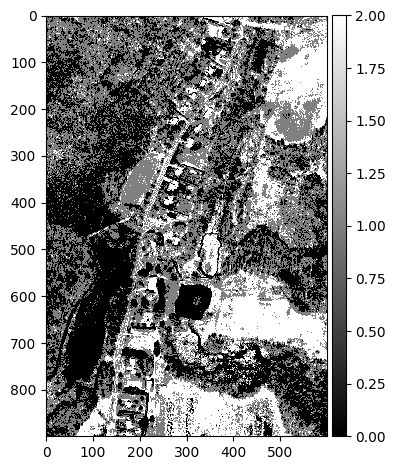

In [25]:
skio.imshow(sk_segmented_image, cmap='gray')

In [26]:
np.unique(sk_segmented_image)

array([0, 1, 2], dtype=int32)

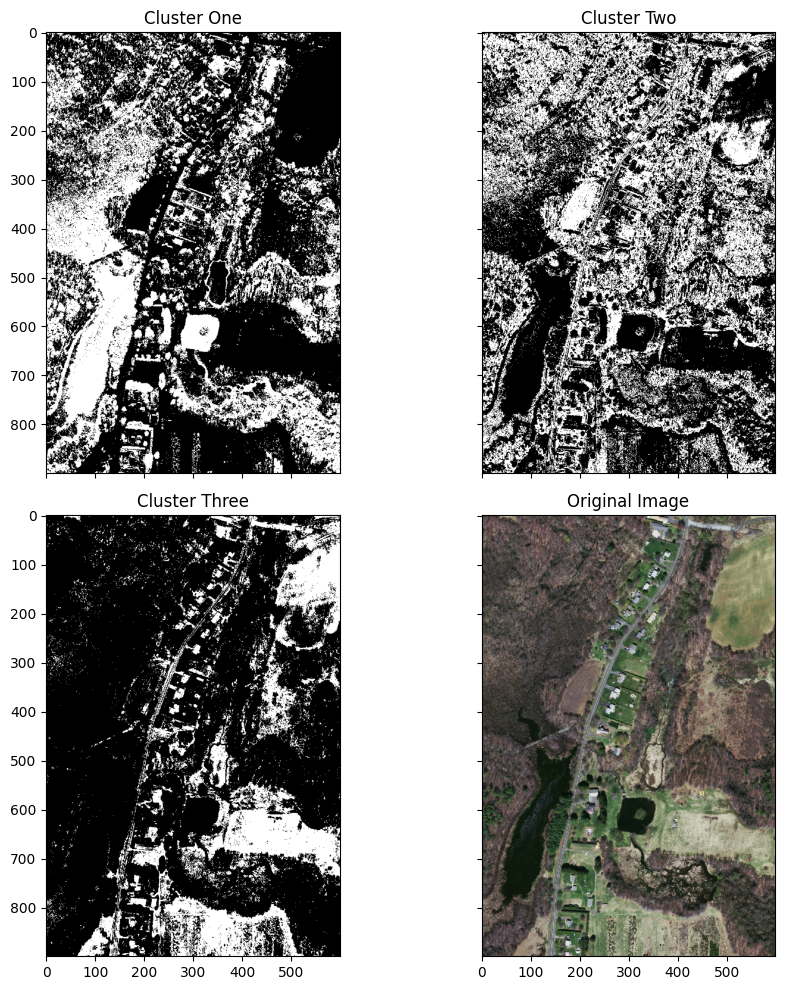

In [27]:
# Generating figure 2
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

cluster_one = (sk_segmented_image==0)
axes[0][0].imshow(cluster_one, cmap='gray')
axes[0][0].set_title('Cluster One')

cluster_two = (sk_segmented_image==1)
axes[0][1].imshow(cluster_two, cmap='gray')
axes[0][1].set_title('Cluster Two')

cluster_three = (sk_segmented_image==2)
axes[1][0].imshow(cluster_three, cmap='gray')
axes[1][0].set_title('Cluster Three')

axes[1][1].imshow(image)
axes[1][1].set_title('Original Image')


plt.tight_layout()
plt.show()

### Hough Transform for detecting straight edges

In [28]:
lines = transform.probabilistic_hough_line(closed_edges, threshold=20, line_length=20, line_gap=3)

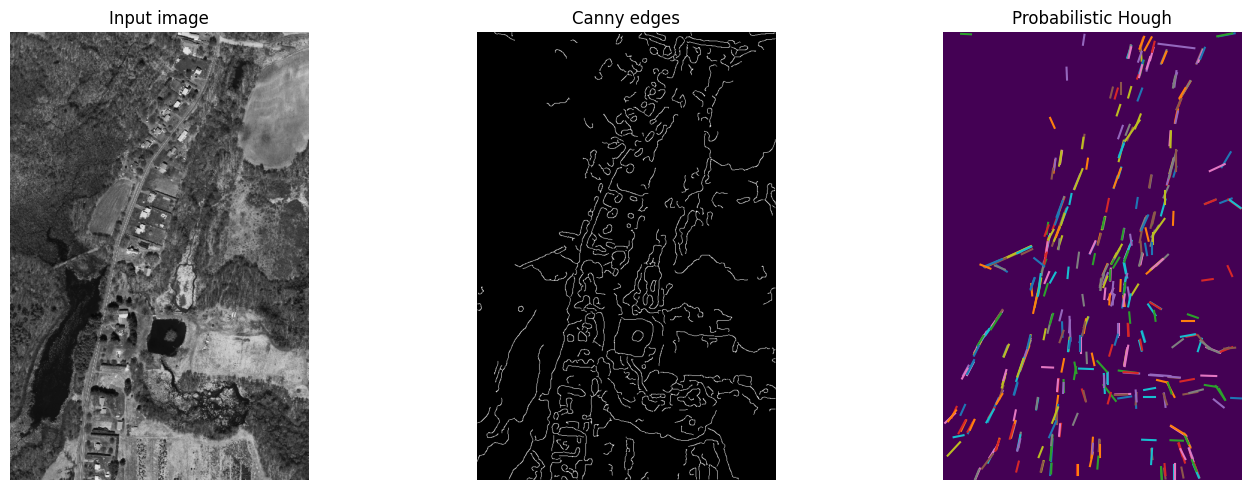

In [29]:
# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_gray, cmap='gray')
ax[0].set_title('Input image')

ax[1].imshow(canny_edges, cmap='gray')
ax[1].set_title('Canny edges')

ax[2].imshow(canny_edges * 0)
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
ax[2].set_xlim((0, image_gray.shape[1]))
ax[2].set_ylim((image_gray.shape[0], 0))
ax[2].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

## Let's try to classify gray pixels, these may help identify the roads

In [42]:
def classify_gray(image):

    # Convert the image to Lab color space

    # Compute the standard deviation of the r, g, and b channels
    # std_dev = np.std(image[:,:,0], image[:,:,1], image[:,:,2])
    std_dev = np.std(image, axis = 2)

    # Define a threshold for classifying gray pixels
    diff_threshold = 6 # Adjust as needed

    # Classify pixels as gray or not gray based on the standard deviation
    gray_mask = std_dev < diff_threshold
        
    return gray_mask

In [43]:
gray_mask = classify_gray(image)
gray_mask = gray_mask.reshape((image.shape[0], image.shape[1]))

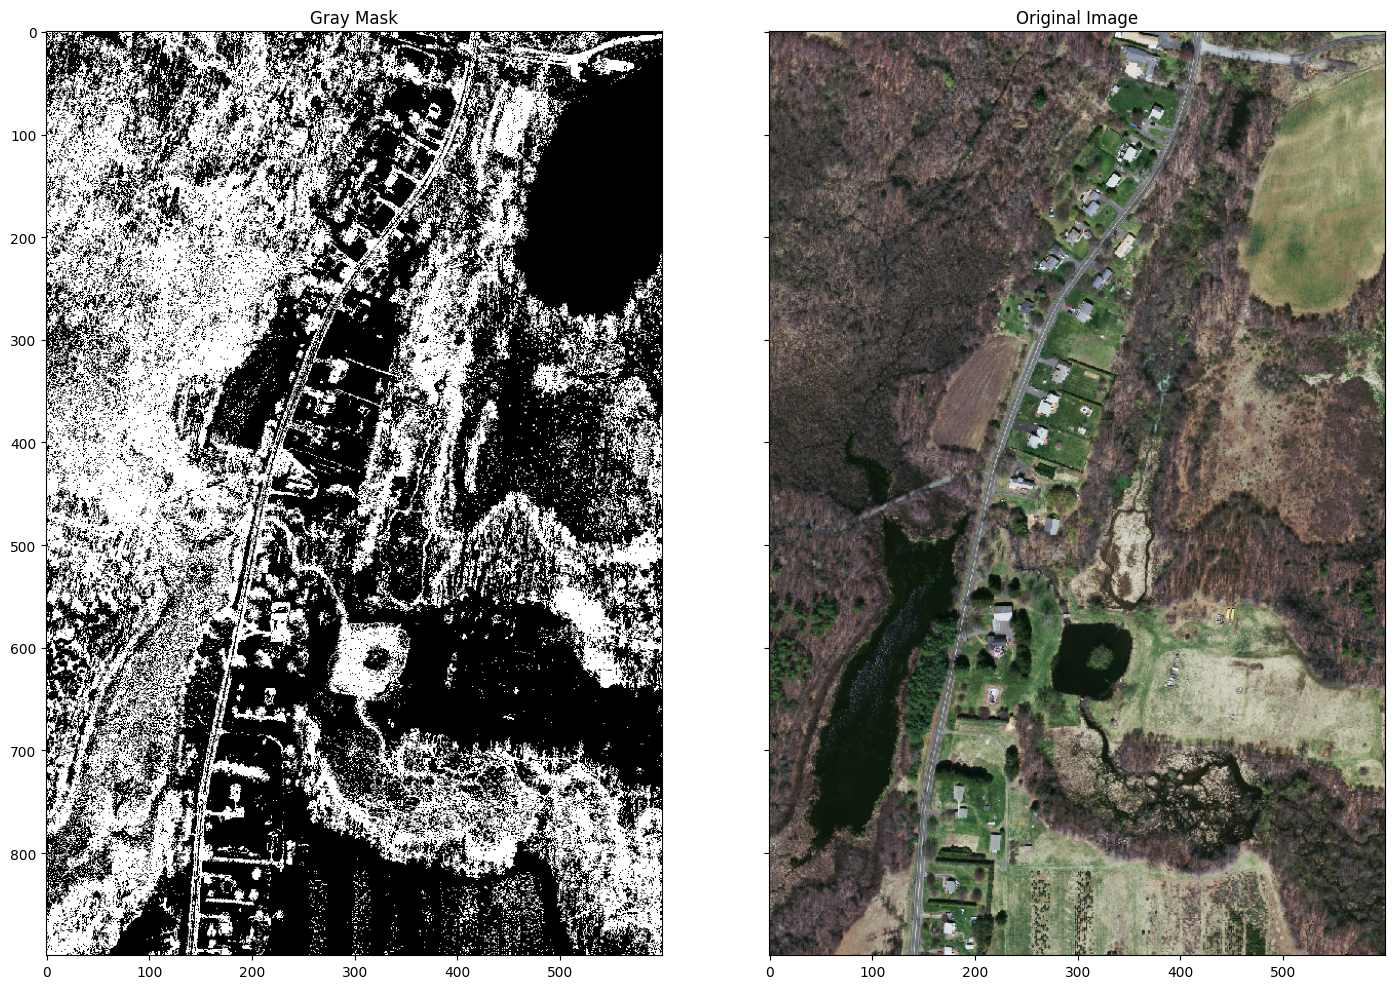

In [44]:
# Generating figure 2
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

axes[0].imshow(gray_mask, cmap='gray')
axes[0].set_title('Gray Mask')

axes[1].imshow(image)
axes[1].set_title('Original Image')

plt.tight_layout()
plt.show()